# Kalman Filters for estimating altitude and vertical velocity in  a variometer

The aim is to estimate altitude and vertical velocity in an altimeter/variometer by fusing altitude and vertical acceleration data inputs.

Altitude measurements are obtained from a barometric pressure sensor. Gravity-compensated vertical acceleration measurements are obtained from an IMU sensor and AHRS software.

As a point of reference, the first algorithm KF2 only uses barometric pressure altitude data and has 2 state variables : altitude and velocity.

KF3 fuses pressure altitude and acceleration data, with 3 state variables : altitude, velocity and acceleration sensor bias. It 'cheats' by using acceleration data in the prediction phase even though acceleration is not included in the state vector, state transition or measurement model. 

KF4 adds acceleration to the state vector. Acceleration data is used in the update phase as part of the measurement model.

KF4d adds adaptive acceleration uncertainty injection into the update phase. This enables quick response to large accelerations while reducing jitter when there is low or no acceleration. It also allows the acceleration bias estimate to evolve only when the acceleration magnitude is low.

The KF4d algorithm provides the best real-world performance at the cost of increased code complexity, size and execution time compared to KF3. 

Our application is implemented on an ESP32 microcontroller with 4MBytes of flash and clocked at 80MHz. There is no issue with the increased code size, and execution time is still acceptable given our real-time data sampling constraints.

***

# KF2

## KF2 : process model

$k$ is the sample time index

$z_{k}$ is the altitude, in $cm$

$v_{k}$ is the vertical velocity, in $cm/s$

$a_{k}$ is the random acceleration perturbation, treated as noise

$dt$ is the time interval between samples

$z_{k}=z_{k-1}+dt*v_{k-1}+(dt^{2}/2)*a_{k-1}$

$v_{k}=v_{k-1}+dt*a_{k-1}$



## KF2 : process model  state transition representation

In matrix notation,

$\left[\begin{array}{c}
z_{k}\\
v_{k}
\end{array}\right]=\left[\begin{array}{cc}
1 & dt\\
0 & 1
\end{array}\right]\left[\begin{array}{c}
z_{k-1}\\
v_{k-1}
\end{array}\right]+\left[\begin{array}{c}
(dt^{2}/2)\\
dt
\end{array}\right]a_{k-1}$

which is a state transition equation in the form

$x_{k}=Fx_{k-1} + w_{k}$

where $x_{k}$ is the state vector 

$x_{k}=\left[\begin{array}{c}
z_{k}\\
v_{k}
\end{array}\right]$

$F$ is the state transition matrix

$F=\left[\begin{array}{cc}
1 & dt\\
0 & 1
\end{array}\right]$

$w_{k}$ is the process noise vector, in which $a_{k}$ represents the random acceleration noise

$w_{k}=\left[\begin{array}{c}
dt^{2}/2\\
dt
\end{array}\right]a_{k}$

The process state covariance matrix $P_{k} = E(x_{k}*x_{k}^{T})$

$P_{k}=\left[\begin{array}{cc}
P_{zz} & P_{zv}\\
P_{vz} & P_{vv}
\end{array}\right]$

Note the state covariance matrix is symmetric, i.e. $P_{zv} = P_{vz}$. 

## KF2 : sensor measurements

In general, the measurement model applies to a subset of the state vector variables and can be written as 

$m_{k} = H_{k}*x_{k} + \eta_{k}$

where $m_{k}$ is the measurement vector, $H_{k}$ is the measurement model matrix transforming the process state vector to measurement vector space, and $\eta$ is the measurement noise vector which is described by a zero-mean Gaussian probability distribution.

In the KF2 model, a barometric sensor provides periodic measurements for pressure altitude ($z_{m}$). These measurements are assumed to be corrupted by sensor noise ($\eta_{z}$). 

The sensor measurement $z_{m_{k}}$ is related to the true altitude $z_{k}$ by the equation

$\begin{aligned}z_{m_{k}} = z_{k} + \eta_{z_{k}}\end{aligned}$


In matrix notation

$\left[z_{m_{k}}\right] = \left[\begin{array}{c}
\begin{array}{cc}
1 & 0\end{array}\end{array}\right]\left[\begin{array}{c}
z_{k}\\
v_{k}
\end{array}\right]+\left[\eta_{z_{k}}\right]$

In this specific case, $m_{k}$ and $\eta_{k}$ are scalars, 

$H_{k}=\left[\begin{array}{cc}
1 & 0\end{array}\right]$

## KF2 : prediction

The process noise covariance matrix $Q_{k}=E(w_{k}*w_{k}^{T})$

$Q_{k}=\left[\begin{array}{cc}
(dt^{4}/4) & (dt^{3}/2)\\
(dt^{3}/2) & dt^{2}
\end{array}\right]\sigma_{a}^{2}$

where $\sigma_{a}^{2}$ is the variance of the acceleration noise

Assuming process model noise is additive and zero-mean, the predicted (a priori) state estimate $\hat{x_{k}^{-}}$ is 

$\hat{x_{k}^{-}}=F_{k-1}*\hat{x_{k-1}^{+}}$

$z_{k}^{-}=z_{k-1}^{+}+(v_{k-1}^{+}*dt)v_{k}^{-}=v_{k-1}^{+}$

The predicted (a priori) state covariance estimate $P_{k}^{-}$ is

$P_{k}^{-}=F_{k-1}*P_{k-1}^{+}*F_{k-1}^{T}+Q_{k-1}$

## KF2 : update

We update the predicted state estimate $\hat{x_{k}^{-}}$ using the new measurement $m_{k}$ to generate the best estimate $\hat{x_{k}^{+}}$ at time sample $k$. 

The predicted measurement $\hat{m_{k}}$ is

$\hat{m_{k}}=H_{k}*\hat{x_{k}^{-}}$

The innovation (or error) $\tilde{y_{k}}$ is the difference between the new measurement $m_{k}$ and the predicted measurement $\hat{m_{k}}$ :

$\tilde{y_{k}} = m_{k}-\hat{m_{k}}$

The measurement noise covariance $R_{k}$ is 

$R_{k} = E(\eta_{z_{k}}*\eta_{z_{k}}^{T})$

In this case $R_{k}$ is a scalar = $\sigma_{z_{m}}^{2}$ where $\sigma_{z_{m}}^{2}$ is the statistical variance of the altitude sensor noise distribution.

The innovation covariance $S_{k}$ is 

$S_{k} = H_{k}*P_{k}^{-}*H_{k}^{T}+R_{k}$

$S_{k}=\left[\begin{array}{cc}
1 & 0\end{array}\right]P_{k}^{-1}\left[\begin{array}{c}
1\\
0
\end{array}\right]+\sigma_{z_{m}}^{2}$

$S_{k}=P_{zz}+\sigma_{z_{m}}^{2}$

In this model, $S_{k}$ is also a scalar variable.

The updated (a posteriori) best state estimate $\hat{x_{k}^{+}}$ is

$\hat{x_{k}^{+}} = \hat{x_{k}^{-}}+K_{k}*\tilde{y_{k}}$

where $K_{k}$ is the 2x1 Kalman gain matrix calculated as a ratio of the current state uncertainty mapped to measurement space, and measurement uncertainty $S_{k}$.

$K_{k} = (P_{k}^{-}*H_{k}^{T})*S_{k}^{-1}$

$K_{k} = P_{k}^{-}\left[\begin{array}{c}
1\\
0
\end{array}\right]\frac{1}{(P_{zz}+\sigma_{z_{m}}^{2})}$

$K_{k} = \frac{1}{(P_{zz}+\sigma_{z_{m}}^{2})}\left[\begin{array}{c}
P_{zz}\\
P_{vz}
\end{array}\right]$

So the updated (a posteriori) best state estimate is a blend between the predicted state estimate and the new measurement depending on the relative uncertainty in predicted state estimate and uncertainty in the new measurement.

The updated (a posteriori) state covariance estimate $P_{k}^{+}$ is

$P_{k}^{+} = (I - K_{k}*H_{k})*P_{k}^{-}$

When the filter is working as expected, the process covariance $trace(P_{k}^{+})$ should reduce as new measurements arrive.

Note that for algorithm initialization covariance matrix trace is set to values large enough to capture the expected state, but not so large that convergence takes an unnecessarily long time. The non-diagonal values are set to 0.

***

# KF3


##  KF3 : process model

$k$ is the sample time index

$z_{k}$ is the altitude, in $cm$

$v_{k}$ is the vertical velocity, in $cm/s$

$a_{k}$ is the vertical acceleration, in $cm/s^{2}$

$b_{k}$ is the vertical acceleration bias, in $cm/s^{2}$. This is the residual bias after accelerometer calibration and can drift unpredictably.

The true vertical acceleration is the measured acceleration minus the acceleration bias.

These variables at time index $k$ are related to the variables at time $k-1$ by the equations 

$z_{k}=z_{k-1}+dt*v_{k-1}+\frac{dt^{2}}{2}*(a_{k-1}-b_{k-1})$	
$v_{k}=v_{k-1}+dt*(a_{k-1}-b_{k-1})$	
$b_{k}=b_{k-1}+\eta_{b}$	

where $dt$ is the time interval between samples and $\eta_{b}$ is a random variable representing acceleration bias noise.

## KF3 : process model state transition representation

In vector/matrix notation, these equations can be written as

$\left[\begin{array}{c}
z_{k}\\
v_{k}\\
b_{k}
\end{array}\right]=\left[\begin{array}{ccc}
1 & dt & \frac{-dt^{2}}{2}\\
0 & 1 & -dt\\
0 & 0 & 1
\end{array}\right]\left[\begin{array}{c}
z_{k-1}\\
v_{k-1}\\
b_{k-1}
\end{array}\right]+\left[\begin{array}{cc}
\frac{dt^{2}}{2} & 0\\
dt & 0\\
0 & 1
\end{array}\right]\left[\begin{array}{c}
a_{k-1}\\
\eta_{b}
\end{array}\right]$

which is a state-transition equation in the form

$x_{k}=Fx_{k-1}+Lw_{k}$

where $x_{k}$ is our state vector 

$x_{k}=\left[\begin{array}{c}
z_{k}\\
v_{k}\\
b_{k}
\end{array}\right]$

$F$ is the state transition matrix

$F=\left[\begin{array}{ccc}
1 & dt & \frac{-dt^{2}}{2}\\
0 & 1 & -dt\\
0 & 0 & 1
\end{array}\right]$

$w_{k}$ is the process noise (environmental perturbation), in which $a_{k}$ represents the random acceleration input, and $\eta_{b}$ is a random variable representing acceleration bias noise

$w_{k}=\left[\begin{array}{c}
a_{k}\\
\eta_{b}
\end{array}\right]$

$L$ is the process noise transformation matrix

$L=\left[\begin{array}{cc}
\frac{dt^{2}}{2} & 0\\
dt & 0\\
0 & 1
\end{array}\right]$

The process state covariance matrix $P_{k} = E(x_{k}*x_{k}^{T})$

$P_{k}=\left[\begin{array}{ccc}
P_{zz} & P_{zv} & P_{zb}\\
P_{vz} & P_{vv} & P_{vb}\\
P_{bz} & P_{bv} & P_{bb}
\end{array}\right]$

Note the state covariance matrix is symmetric, i.e. $P_{zv}=P_{vz}, P_{zb}=P_{bz}, P_{vb}=P_{bv}$. 

## KF3 : sensor measurements

$m_{k} = H_{k}*x_{k}+\eta_{k}$

where $m_{k}$ is the measurement vector, $H_{k}$ is the measurement model matrix transforming the process state vector to measurement vector space, and $\eta$ is the measurement noise vector which is described by a zero-mean Gaussian probability distribution.

As in the KF2 model, the barometric sensor provides periodic measurements for altitude ($z_{m}$). These measurements are assumed to be corrupted by sensor noise ($\eta$) which is described by a zero-mean Gaussian probability distribution. 

So, the sensor measurement $z_{m_{k}}$ is related to the true altitude $z_{k}$ by the equation

$\begin{aligned}z_{m_{k}} = z_{k} + \eta_{z_{k}}\\
\\
\end{aligned}$


In vector/matrix notation

$\left[z_{m_{k}}\right]=\left[\begin{array}{c}
\begin{array}{ccc}
1 & 0 & 0\end{array}\end{array}\right]\left[\begin{array}{c}
z_{k}\\
v_{k}\\
b_{k}
\end{array}\right] + \left[\eta_{z_{k}}\right]$

Again, $m_{k}$ and $\eta_{k}$ are scalars.

$H_{k} = \left[\begin{array}{cc}
1 & 0 & 0\end{array}\right]$

Note that we are also getting periodic gravity-compensated acceleration measurements $a_{k}$, but we cheat and use the acceleration measurements as input in the prediction step.

## KF3 : prediction

Assuming the process noise $w$ components can be described by zero-mean gaussian probability distributions, the process noise covariance matrix $Q_{k}$ is 

$Q_{k}=L*E(w_{k}*w_{k}^{T})*L^{T}$

Let

$N_{k}=E(w_{k}*w_{k}^{T})$

$N_{k}=\left[\begin{array}{cc}
\sigma_{a}^{2} & 0\\
0 & \sigma_{b}^{2}
\end{array}\right]$

where $\sigma_{a}^{2}$ is the statistical variance of acceleration perturbations from the environment, and $\sigma_{b}^{2}$ is the statistical variance of acceleration bias noise.

$Q_{k}=L*N_{k}*L^{T}$

$Q_{k}=\left[\begin{array}{ccc}
(\frac{dt^{4}}{4}\sigma_{a}^{2}) & (\frac{dt^{3}}{2}\sigma_{a}^{2}) & 0\\
(\frac{dt^{3}}{2}\sigma_{a}^{2}) & (dt^{2}\sigma_{a}^{2}) & 0\\
0 & 0 & \sigma_{b}^{2}
\end{array}\right]$

Assuming process model noise is additive and zero-mean, the predicted (a priori) state estimate $\hat{x_{k}^{-}}$ is 

$\hat{x_{k}^{-}}=F_{k-1}*\hat{x_{k-1}^{+}}$

where $\hat{x_{k-1}^{+}}$ is the updated (a posteriori) best state estimate for index $k-1$.

Here we cheat and use the measured gravity-compensated acceleration $am_{k}$ to predict $z_{k}^{-}$ and $v_{k}^{-}$ using 

$z_{k}^{-}=z_{k-1}^{+}+(v_{k-1}^{+}*dt)v_{k}^{-}=v_{k-1}^{+}+(am_{k-1}-b_{k-1})*dt)$

The predicted (a priori) state covariance estimate $P_{k}^{-}$ is

$P_{k}^{-}=F_{k-1}*P_{k-1}^{+}*F_{k-1}^{T}+Q_{k-1}$

## KF3 : update

We update the predicted state estimate $\hat{x_{k}^{-}}$ using the new measurement $m_{k}$ to generate the best estimate $\hat{x_{k}^{+}}$ at time sample $k$. 

The predicted measurement $\hat{m_{k}}$ is

$\hat{m_{k}} = H_{k}*\hat{x_{k}^{-}}$

The innovation (or error) $\tilde{y_{k}}$ is the difference between the new measurement $m_{k}$ and the predicted measurement $\hat{m_{k}}$ :

$\tilde{y_{k}} = m_{k} - \hat{m_{k}}$

The measurement noise covariance $R_{k}$ is 

$R_{k}=E(\eta_{k}*\eta_{k}^{T})$

In this specific case $R_{k}$ is a scalar = $\sigma_{z_{m}}^{2}$ where $\sigma_{z_{m}}^{2}$ is the statistical variance of the altitude sensor noise distribution.

The innovation covariance $S_{k}$ is 

$S_{k} = H_{k}*P_{k}^{-}*H_{k}^{T}+R_{k}$

$S_{k}=\left[\begin{array}{ccc}
1 & 0 & 0\end{array}\right]P_{k}^{-1}\left[\begin{array}{c}
1\\
0\\
0
\end{array}\right]+\sigma_{z_{m}}^{2}$

$S_{k}=P_{zz}+\sigma_{z_{m}}^{2}$

In this model, $S_{k}$ is also a scalar variable.

The updated (a posteriori) best state estimate $\hat{x_{k}^{+}}$ is

$\hat{x_{k}^{+}} = \hat{x_{k}^{-}}+K_{k}*\tilde{y_{k}}$

where $K_{k}$ is the 3x1 Kalman gain matrix calculated as a ratio of the current state uncertainty mapped to measurement space, and measurement uncertainty $S_{k}$.

$K_{k} = (P_{k}^{-}*H_{k}^{T})*S_{k}^{-1}$

$K_{k} = P_{k}^{-}\left[\begin{array}{c}
1\\
0\\
0
\end{array}\right]\frac{1}{(P_{zz}+\sigma_{z_{m}}^{2})}$

$K_{k}=\frac{1}{(P_{zz}+\sigma_{z_{m}}^{2})}\left[\begin{array}{c}
P_{zz}\\
P_{vz}\\
P_{bz}
\end{array}\right]$

So the updated (a posteriori) best state estimate is a blend between the predicted state estimate and the new measurement depending on the relative uncertainty in predicted state estimate and uncertainty in the new measurement.

The updated (a posteriori) state covariance estimate $P_{k}^{+}$ is

$P_{k}^{+}=(I-K_{k}*H_{k})*P_{k}^{-}$

When the filter is working as expected, the process covariance $trace(P_{k}^{+})$ should reduce as new measurements arrive.

***


# KF4

The KF3 algorithm uses sensor acceleration measurements in the prediction phase without including acceleration in the state transition matrix, or in the measurement model. 

The KF4 algorithm explicitly includes acceleration in the process state vector, state transition and measurement model. 

## KF4 : process model 

$k$ is the sample index

$z_{k}$ is the altitude sample, in $cm$

$v_{k}$ is the vertical velocity, in $cm/s$

$a_{k}$ is the vertical acceleration, in $cm/s^{2}$

$b_{k}$ is the vertical acceleration bias, in $cm/s^{2}$. This is the residual acceleration bias after accelerometer calibration and is assumed to drift unpredictably. The true vertical acceleration is the measured acceleration minus the acceleration bias.

These variables at time index $k$ are related to the state variables at time $k-1$ by the equations

$\begin{aligned}z_{k}=z_{k-1}+dt*v_{k-1}+(dt^{2}/2)*(a_{k-1}-b_{k-1})\\
v_{k}=v_{k-1}+dt*(a_{k-1}-b_{k-1})\\
a_{k}=a_{k-1}+\eta_{a}\\
b_{k}=b_{k-1}+\eta_{b}
\end{aligned}$

where $\eta_{a}$ represents the random acceleration perturbation from the environment, and $\eta_{b}$ represents the random acceleration bias noise input.

This is our physical process model.

## KF4 : process model state transition representation

In vector/matrix notation, the physical process model can be written as

$\left[\begin{array}{c}
z_{k}\\
v_{k}\\
a_{k}\\
b_{k}
\end{array}\right]=\left[\begin{array}{cccc}
1 & dt & (dt^{2}/2) & (-dt^{2}/2)\\
0 & 1 & dt & -dt\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1
\end{array}\right]\left[\begin{array}{c}
z_{k-1}\\
v_{k-1}\\
a_{k-1}\\
b_{k-1}
\end{array}\right]+\left[\begin{array}{cc}
0 & 0\\
0 & 0\\
1 & 0\\
0 & 1
\end{array}\right]\left[\begin{array}{c}
\eta_{a}\\
\eta_{b}
\end{array}\right]$

or

$x_{k}=F_{k}*x_{k-1}+L_{k}*w_{k}$

where $x$ is the process model state vector, $F$ is the state transition matrix, $w$ is the process model noise vector, and $L$ is the process model noise sensitivity matrix.

The process state covariance matrix $P_{k} = E(x_{k}*x_{k}^{T})$

$P_{k}=\left[\begin{array}{cccc}
P_{zz} & P_{zv} & P_{za} & P_{zb}\\
P_{vz} & P_{vv} & P_{va} & P_{vb}\\
P_{az} & P_{av} & P_{aa} & P_{ab}\\
P_{bz} & P_{bv} & P_{ba} & P_{bb}
\end{array}\right]$

Note that $P_{k}$ is a symmetric matrix.

## KF4 : sensor measurements

$m_{k} = H_{k}*x_{k} + \eta_{k}$

where $m_{k}$ is the measurement vector, $H_{k}$ is the measurement model matrix transforming the process state vector to the measurement vector space, and $\eta_{k}$ is the measurement noise vector. 

In this model, sensors provide periodic measurements for altitude $z_{m}$ and vertical acceleration $a_{m}$. These measurements are assumed to be corrupted by altitude sensor noise $\eta_{z}$ and acceleration sensor noise $\eta_{a}$ which have zero-mean Gaussian probability distributions. 

The sensor measurements are related to the process model state variables by the equations

$\begin{aligned}z_{m_{k}}= z_{k} + \eta_{z_{k}}\\
a_{m_{k}} = a_{k} + \eta_{a_{k}}
\end{aligned}$

In vector/matrix notation

$\left[\begin{array}{c}
z_{m_{k}}\\
a_{m_{k}}
\end{array}\right] = \left[\begin{array}{cccc}
1 & 0 & 0 & 0\\
0 & 0 & 1 & 0
\end{array}\right]\left[\begin{array}{c}
z_{k}\\
v_{k}\\
a_{k}\\
b_{k}
\end{array}\right]+\left[\begin{array}{c}
\eta_{z_{k}}\\
\eta_{a_{k}}
\end{array}\right]$


## KF4 : prediction

Assuming the process noise $w$ components can be described by zero-mean gaussian probability distributions, the process noise covariance matrix $Q_{k}$ is 

$Q_{k} = L*E(w_{k}*w_{k}^{T})*L^{T}$

or

$Q_{k} = L*N_{k}*L^{T}$

where 

$N_{k}=\left[\begin{array}{cc}
\sigma_{a}^{2} & 0\\
0 & \sigma_{b}^{2}
\end{array}\right]$

where $\sigma_{a}^{2}$ is the statistical variance of the external random acceleration input, and $\sigma_{b}^{2}$ is the statistical variance of the acceleration sensor bias.

$Q_{k}=\left[\begin{array}{cccc}
0 & 0 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & \sigma_{a}^{2} & 0\\
0 & 0 & 0 & \sigma_{b}^{2}
\end{array}\right]$

The predicted (a priori) state estimate $\hat{x_{k}^{-}}$ (assuming process model noise is additive zero-mean Gaussian) is 

$\hat{x_{k}^{-}} = F_{k-1}*\hat{x_{k-1}^{+}}$

The predicted (a priori) state covariance estimate $P_{k}^{-}$ is

$P_{k}^{-} = F_{k-1}*P_{k-1}^{+}*F_{k-1}^{T}+Q_{k-1}$

## KF4 : update

We update the predicted state estimate $\hat{x_{k}^{-}}$ using the new measurement $m_{k}$ to generate the best estimate $\hat{x_{k}^{+}}$ at time sample $k$. 

The predicted measurement $\hat{m_{k}}$ is

$\hat{m_{k}}=H_{k}*\hat{x_{k}^{-}}$

The innovation (or error) $\tilde{y_{k}}$ is the difference between the new measurement $m_{k}$ and the predicted measurement $\hat{m_{k}}$ :

$\tilde{y_{k}} = m_{k}-\hat{m_{k}}$

The measurement noise covariance $R_{k}$ is 

$R_{k} = E(\eta_{k}*\eta_{k}^{T})$

$R_{k}=\left[\begin{array}{cc}
\sigma_{z_{m}}^{2} & 0\\
0 & \sigma_{a_{m}}^{2}
\end{array}\right]$

where $\sigma_{z_{m}}^{2}$ is the statistical variance of the altitude sensor noise, and $\sigma_{a_{m}}^{2}$ is the statistical variance of the acceleration sensor noise.

The innovation covariance $S_{k}$ is 

$S_{k} = H_{k}*P_{k}^{-}*H_{k}^{T}+R_{k}$

The updated (a posteriori) state estimate $\hat{x_{k}^{+}}$ is

$\hat{x_{k}^{+}}=\hat{x_{k}^{-}}+K_{k}*\tilde{y_{k}}$

where $K_{k}$ is the 4x2 Kalman gain matrix. $K_{k}$ is the ratio of the current state uncertainty mapped to measurement space, and measurement uncertainty.

$K_{k} = (P_{k}^{-}*H_{k}^{T})*S_{k}^{-1}$

So the updated (a posteriori) best estimate $x_{k}^{+}$ is a blend between the predicted state estimate $x_{k}^{-}$ and the new measurement $m_{k}$, based on the relative uncertainty in state estimate and uncertainty in the new measurement.

The updated (a posteriori) state covariance estimate $P_{k}^{+}$ is

$P_{k}^{+} = (I - K_{k}*H_{k})*P_{k}^{-}$

When the filter is working as expected, the process covariance $trace(P_{k}^{+})$ should reduce as new measurements arrive.

***

# KF4d

The KF4d algorithm update phase adaptively adds additional uncertainty to the KF4 acceleration state vector estimation based on the magnitude of the measured acceleration. This allows the algorithm to respond quickly to large acceleration inputs while heavily filtering the state estimation in zero or constant velocity situations.

The algorithm update phase also reduces the added acceleration bias uncertainty when the acceleration is large. This forces the acceleration bias estimate to evolve only when the acceleration magnitude is very low. 

# KF3 versus KF4



## Computation time
On an ESP32 micro clocked at 80MHz, the computation times are :

| Predict + Update | Time |
| ---| --- |
| KF3 | ~45uS |
| KF4 | ~85uS |


## Real-time constraints

We are sampling raw data from an MPU9250 IMU sensor at 500Hz. The sensor readings and all tasks need to be completed well within 2mS. In the worst-case, this is all of the following :

1. Barometric pressure sensor sampling, compensation and pressure-to-altitude conversion (BMP388 = 145uS, MS5611 takes less time)

2. AHRS algorithm to compute orientation and gravity-compensated acceleration (19uS)

3. Kalman filter prediction and update steps (KF4 = 85uS)

4. Data logging to SPI flash. Worst case is IMU+Baro+GPS 80byte record, crossing a flash page boundary (210 uS)

The worst-case total execution time works out to 459uS. Note that ESP32 is a dual-core microcontroller. The other application tasks (UI, GPS, Bluetooth) are executing on a different core. So using the KF4 algorithm is not an issue in this execution environment.

***

# KF2, KF3, KF4, KF4d :  Performance comparison

A high-speed IBG (IMU + Baro+GPS) data log was recorded for this scenario : the gps-vario was initially on the floor next to a table, then raised, lowered nearly to the floor, raised and then lowered to the table. The unit was stationary for a few seconds at the beginnning and at the end.

An IBG data log contains IMU AHRS data recorded at 500 samples/sec, Baro z-altitude data at 50 samples/sec and (if available) GPS data at 10 samples/sec. 

The sensor data was captured with an MS5611 barometric pressure sensor and MPU9250 IMU sensor. 

Note that absolute results (e.g. covariance matrix uncertainty convergence) will differ depending on the static configuration options used and initial settings. 

However, given common settings, the relative performance will track the differences shown here.

The offline algorithm comparison code was compiled and executed in an Ubuntu 20.04 terminal.

To compile the code, execute the script `build.sh`

```
chmod 755 ./build.sh
./build.sh
```

To run the code, there are 4 algorithm options : -kf2, -kf3, -kf4, -kf4d.

```
./kf_run -kf2 ./ms5611_datalog > kf2_results.txt
./kf_run -kf3 ./ms5611_datalog > kf3_results.txt
./kf_run -kf4 ./ms5611_datalog > kf4_results.txt
./kf_run -kf4d ./ms5611_datalog > kf4d_results.txt
```

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt

## Load sensor altitude samples, KF2 algorithm filter results

In [2]:
z = []
z_kf2 = []
v_kf2 = []
pzz_kf2 = []
pvv_kf2 = []
with open('kf2_results.txt', newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=' ')
    for row in csvreader:
        z.append(float(row[0]))
        z_kf2.append(float(row[1]))
        pzz_kf2.append(float(row[2]))
        v_kf2.append(float(row[3]))
        pvv_kf2.append(float(row[4]))
z = np.array(z)        
z_kf2 = np.array(z_kf2)
v_kf2 = np.array(v_kf2)        
pzz_kf2 = np.array(pzz_kf2)        
pvv_kf2 = np.array(pvv_kf2)        

## Load KF3 algorithm filter results

In [3]:
z_kf3 = []
v_kf3 = []
pzz_kf3 = []
pvv_kf3 = []
with open('kf3_results.txt', newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=' ')
    for row in csvreader:
        z_kf3.append(float(row[1]))
        pzz_kf3.append(float(row[2]))
        v_kf3.append(float(row[3]))
        pvv_kf3.append(float(row[4]))
z_kf3 = np.array(z_kf3)
v_kf3 = np.array(v_kf3)        
pzz_kf3 = np.array(pzz_kf3)        
pvv_kf3 = np.array(pvv_kf3)        

## Load KF4 algorithm filter results

In [4]:
z_kf4 = []
v_kf4 = []
pzz_kf4 = []
pvv_kf4 = []
with open('kf4_results.txt', newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=' ')
    for row in csvreader:
        z_kf4.append(float(row[1]))
        pzz_kf4.append(float(row[2]))
        v_kf4.append(float(row[3]))
        pvv_kf4.append(float(row[4]))
z_kf4 = np.array(z_kf4)
v_kf4 = np.array(v_kf4)        
pzz_kf4 = np.array(pzz_kf4)        
pvv_kf4 = np.array(pvv_kf4)        

## Load KF4d algorithm filter results

In [5]:
z_kf4d = []
v_kf4d = []
pzz_kf4d = []
pvv_kf4d = []
with open('kf4d_results.txt', newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=' ')
    for row in csvreader:
        z_kf4d.append(float(row[1]))
        pzz_kf4d.append(float(row[2]))
        v_kf4d.append(float(row[3]))
        pvv_kf4d.append(float(row[4]))
z_kf4d = np.array(z_kf4d)
v_kf4d = np.array(v_kf4d)        
pzz_kf4d = np.array(pzz_kf4d)        
pvv_kf4d = np.array(pvv_kf4d)  

## Altitude Estimation

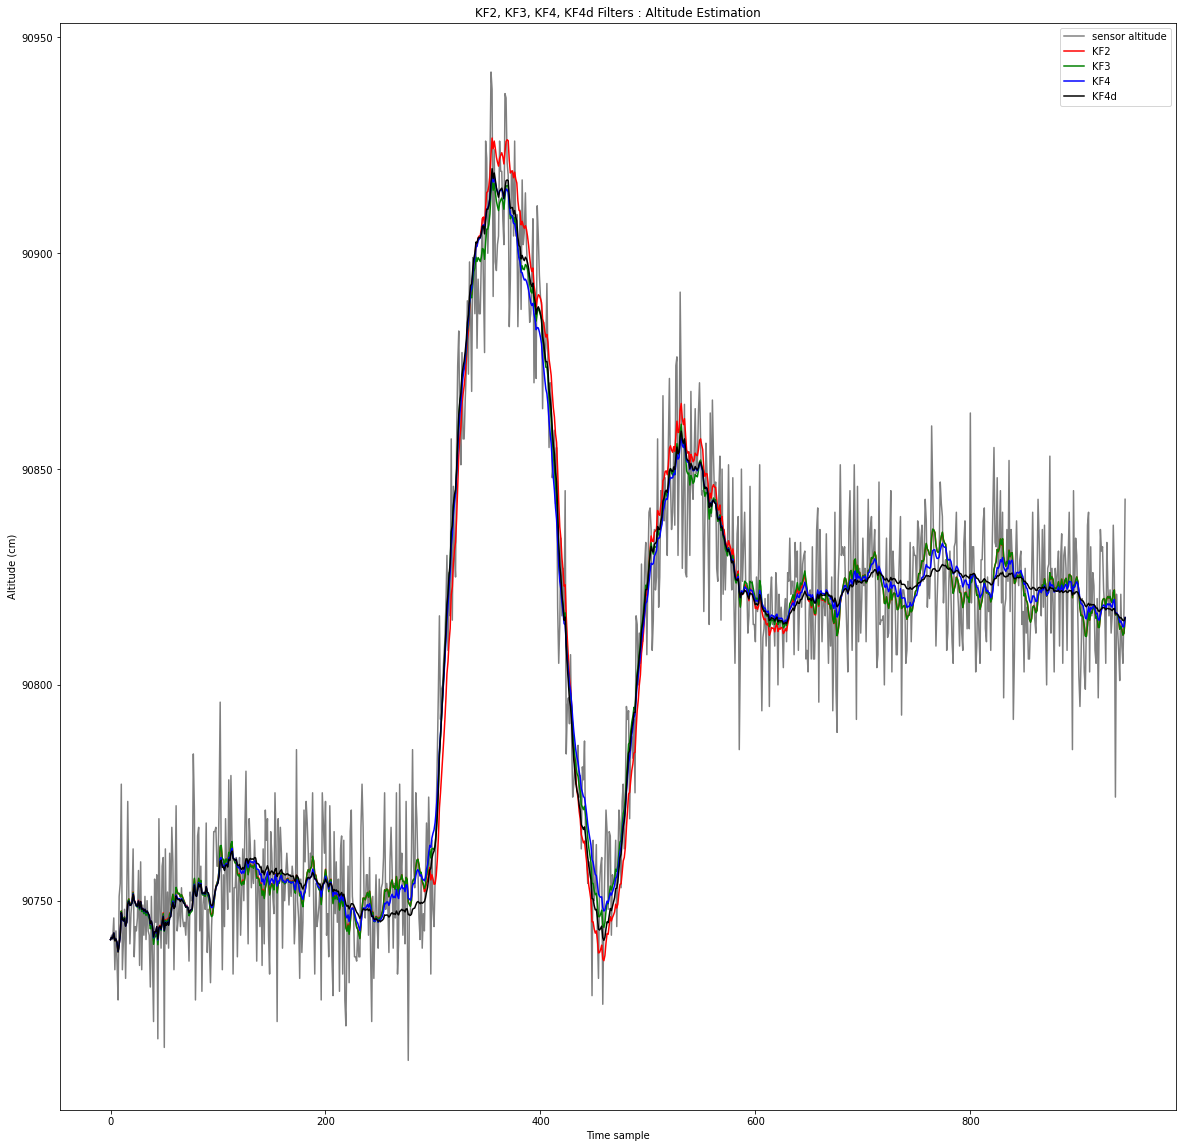

In [6]:
# enlarge the plot size to show more detail
plt.rcParams["figure.figsize"]=20,20

# MS5611 barometric pressure sensor derived altitude samples
plt.plot(z, color='gray', label='sensor altitude')

# KF2 filter only uses the altitude samples
plt.plot(z_kf2, color='red', label='KF2')

# KF3 filter fuses altitude and gravity-compensated acceleration data
plt.plot(z_kf3, color='green', label='KF3')

# KF4 filter fuses altitude and gravity-compensated acceleration data, acceleration update and acceleration
# bias variance are static configuration options
plt.plot(z_kf4, color='blue', label='KF4')

# KF4d filter fuses altitude and gravity-compensated acceleration data, dynamically adds uncertainty to
# Pvv and Pbb covariance elements in update phase depending on the external acceleration magnitude
plt.plot(z_kf4d, color='black', label='KF4d')

plt.title('KF2, KF3, KF4, KF4d Filters : Altitude Estimation')
plt.legend()
plt.xlabel('Time sample')
plt.ylabel('Altitude (cm)')

plt.show()

### Plot a subset of the data for better discrimination

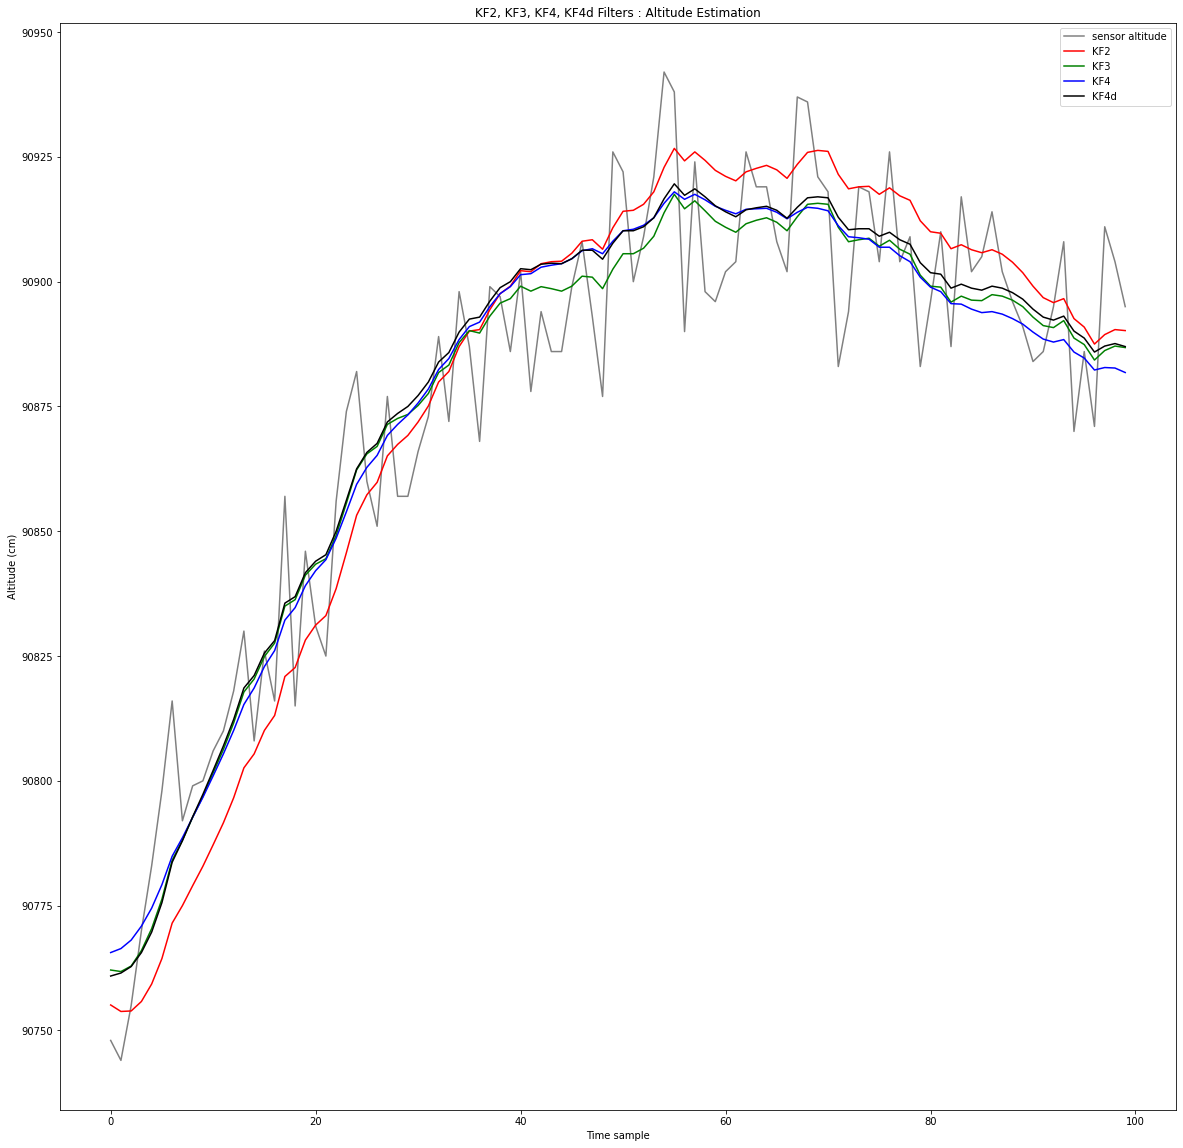

In [7]:
plt.plot(z[300:400], color='gray', label='sensor altitude')
plt.plot(z_kf2[300:400], color='red', label='KF2')
plt.plot(z_kf3[300:400], color='green', label='KF3')
plt.plot(z_kf4[300:400], color='blue', label='KF4')
plt.plot(z_kf4d[300:400], color='black', label='KF4d')
plt.xlabel('Time sample')
plt.ylabel('Altitude (cm)')
plt.title('KF2, KF3, KF4, KF4d Filters : Altitude Estimation')
plt.legend()
plt.show()

## Velocity Estimation

The KF2 filter response lag is visible even without zooming in. The difference is very perceptible for variometer audio feedback. 

We can also see that the KF4d algorithm does a good job of filtering out noise when the acceleration is close to zero (vario is stationary at beginning and end).

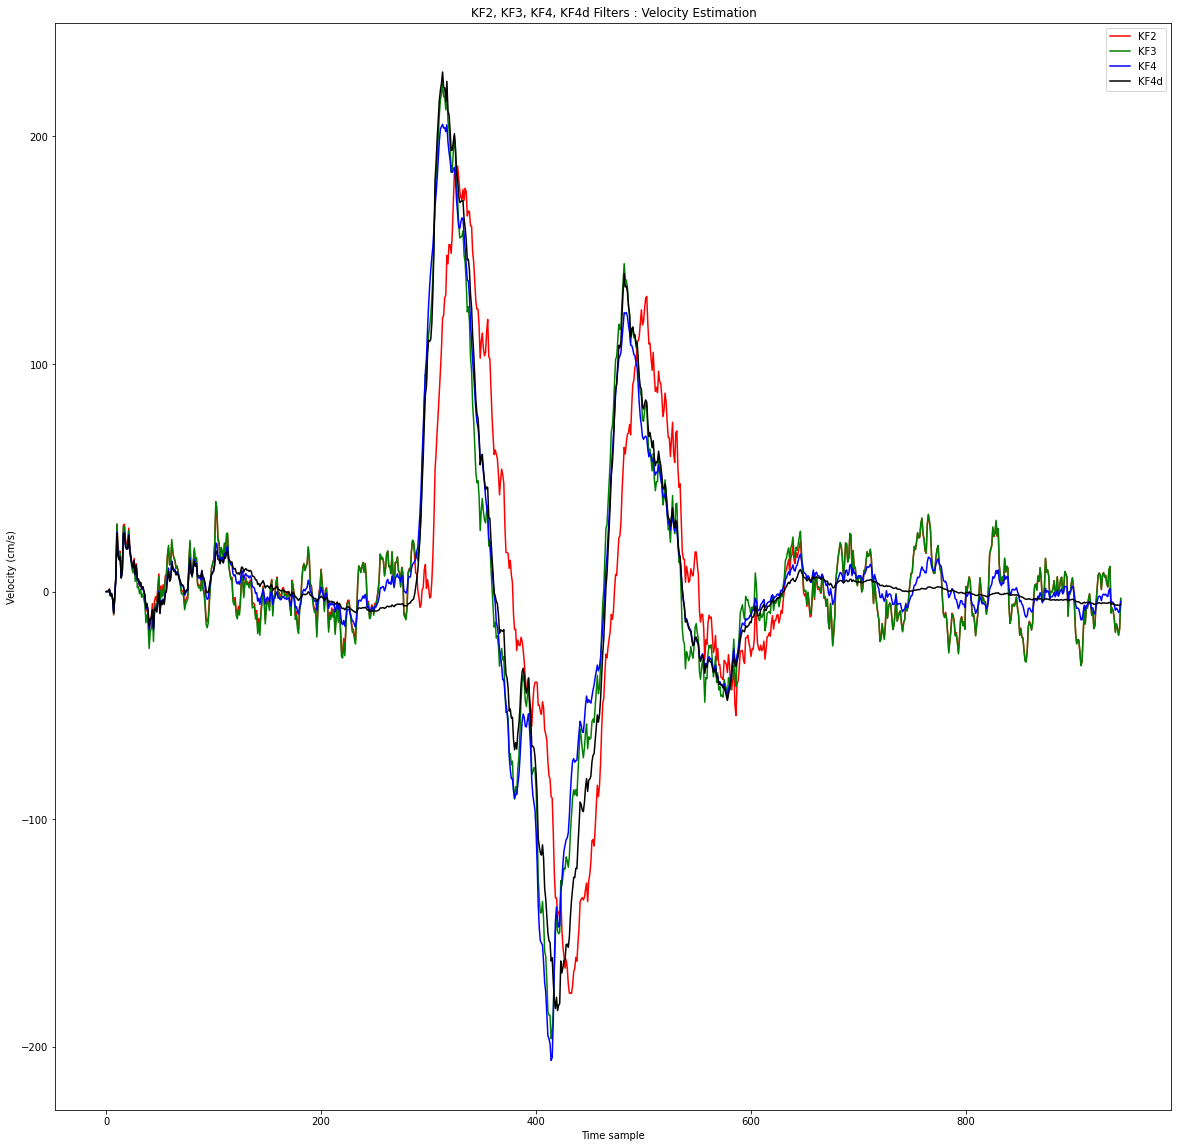

In [8]:
plt.plot(v_kf2, color='red', label='KF2')
plt.plot(v_kf3, color='green', label='KF3')
plt.plot(v_kf4, color='blue', label='KF4')
plt.plot(v_kf4d, color='black', label='KF4d')
plt.title('KF2, KF3, KF4, KF4d Filters : Velocity Estimation')
plt.xlabel('Time sample')
plt.ylabel('Velocity (cm/s)')
plt.legend()
plt.show()

When zoomed in, we can quantify the difference in response. The sample interval is 20mS. KF2 responds to the falling variometer nearly 0.5 seconds later. This demonstrates the benefit of fusing acceleration and altitude readings for minimum-lag variometer response.

The KF4d algorithm matches KF4 for velocity response lag when the acceleration is high, but has a relatively larger lag when the acceleration is low.

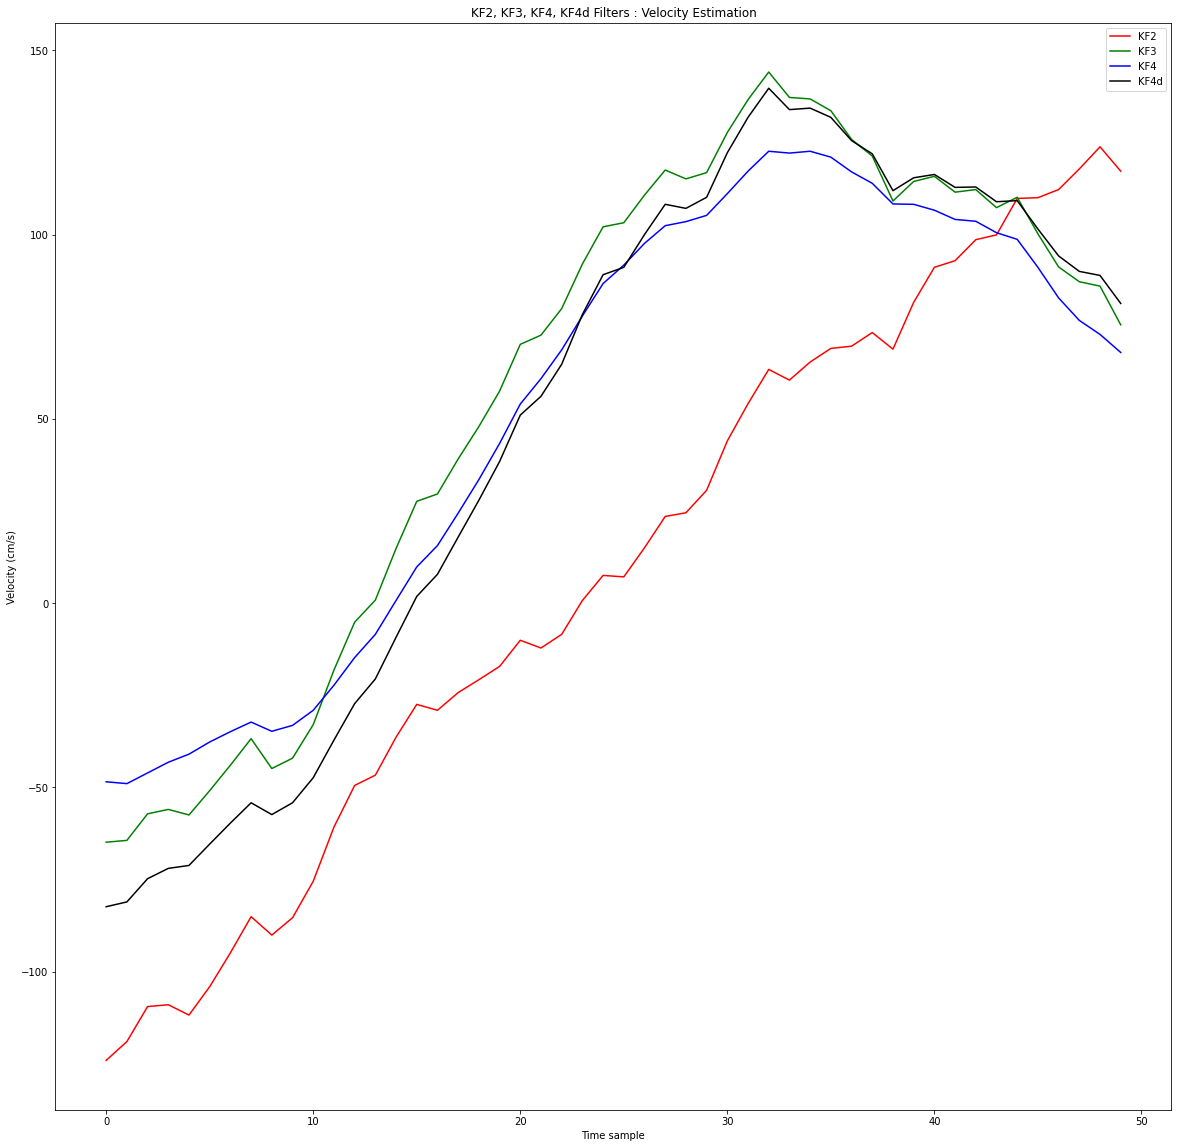

In [9]:
plt.plot(v_kf2[450:500], color='red', label='KF2')
plt.plot(v_kf3[450:500], color='green', label='KF3')
plt.plot(v_kf4[450:500], color='blue', label='KF4')
plt.plot(v_kf4d[450:500], color='black', label='KF4d')
plt.title('KF2, KF3, KF4, KF4d Filters : Velocity Estimation')
plt.xlabel('Time sample')
plt.ylabel('Velocity (cm/s)')
plt.legend()
plt.show()

## Altitude Uncertainty Convergence

Note that for the KF4d algorithm we are artificially adding uncertainty to the state covariance matrix P elements Pvv and Pbb depending on the magnitude of the acceleration detected. This is the reason for the spikes in the regions where the vario is accelerating or decelerating. 

As a result, we get a fast response to large accelerations while also filtering out noise better when the acceleration magnitude is low, i.e. the vario is stationary or moving with nearly constant velocity.

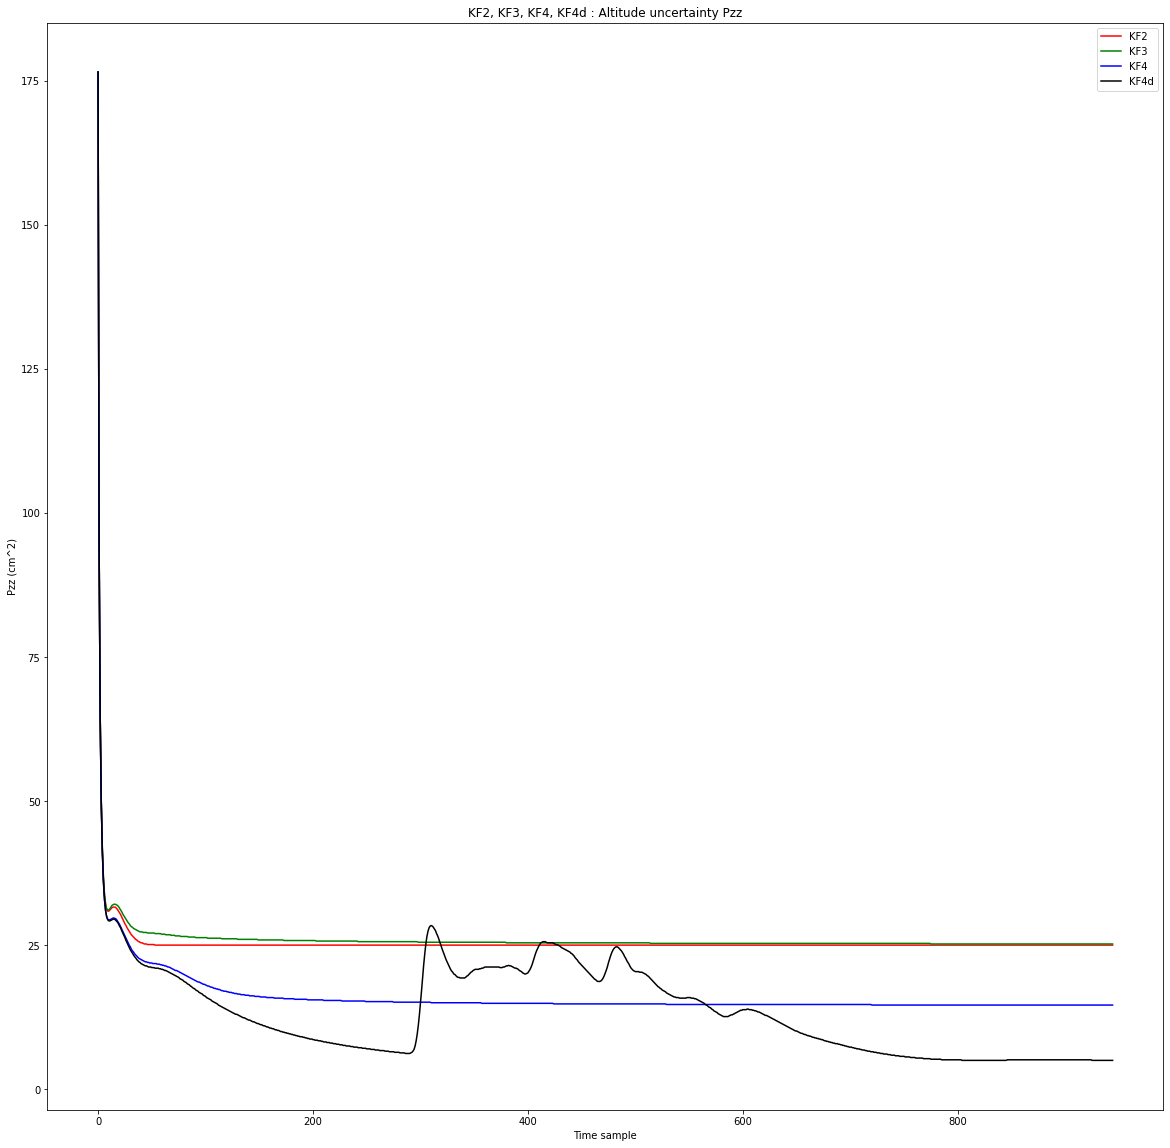

In [10]:
plt.plot(pzz_kf2, color='red', label='KF2')
plt.plot(pzz_kf3, color='green', label='KF3')
plt.plot(pzz_kf4, color='blue', label='KF4')
plt.plot(pzz_kf4d, color='black', label='KF4d')
plt.title('KF2, KF3, KF4, KF4d : Altitude uncertainty Pzz')
plt.xlabel('Time sample')
plt.ylabel('Pzz (cm^2)')
plt.legend()
plt.show()

## Velocity Uncertainty convergence

Note that for the KF4d algorithm we are artificially adding uncertainty to the covariance matrix P elements Pvv and Pbb depending on the magnitude of the detected acceleration. This is the reason for the spikes in the regions where the vario is accelerating or decelerating. 

As a result, we get a fast response to large accelerations while also filtering out noise better when the acceleration magnitude is low, i.e. the vario is stationary or moving with nearly constant velocity.

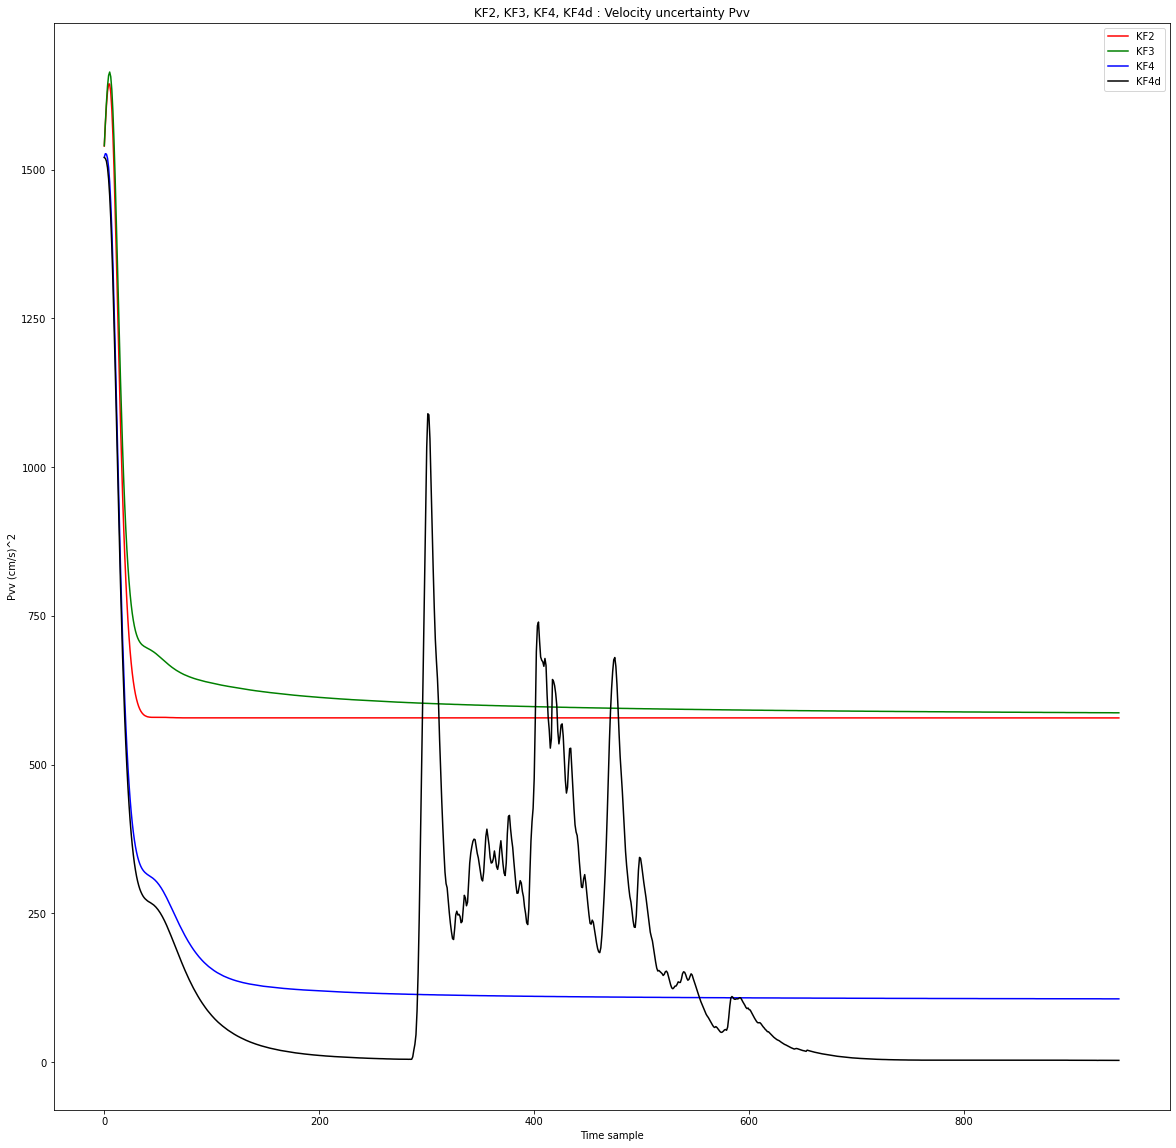

In [11]:
plt.plot(pvv_kf2, color='red', label='KF2')
plt.plot(pvv_kf3, color='green', label='KF3')
plt.plot(pvv_kf4, color='blue', label='KF4')
plt.plot(pvv_kf4d, color='black', label='KF4d')
plt.xlabel('Time sample')
plt.ylabel('Pvv (cm/s)^2')
plt.title('KF2, KF3, KF4, KF4d : Velocity uncertainty Pvv')
plt.legend()
plt.show()

## Altitude and Velocity Uncertainty at end of run 

| Algorithm | Pzz | Pvv |
| --- | --- | --- |
| KF2 | 25.0 | 578.5|
| KF3 | 25.2  | 587.1 |
| KF4 | 14.6 | 106.4 |
| KF4d | 5.0 | 3.0 |

The KF4d algorithm with adaptive acceleration uncertainty and acceleration-bias uncertainty injection has significantly lower velocity uncertainty when the acceleration magnitude is low. 

In terms of variometer audio feedback, there is perceptibly less jitter when the vario is stationary or moving with nearly constant velocity. However, the vario is still able to respond quickly in situations with large accelerations/decelerations.
